In [1]:
import numpy as np
import struct
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

### Automatic speach recognition with neural networks
This notebook uses MFCC pre-prossesing to generate acoustic features to the neural network, and then the neural network can be trained and tested. The baseline consists into HNNs. 

The dataset utilized in this notebook is the speach commands datasets from tensorflow. As this dataset comes with a lot of words and a lots of examples, we choose to simplify this notebook example by focusing in the following words: cat, dog, happy, house and zero. The training set consists into 25 examples of each word, and the testing set consists into 5 new examples of each word.

All the pre-prossecing is made by the spock: . Using this software the user can process WAV files and output the processed acoustic features in `.FEA` files. Then the neural network can receive this accoustic features and output the class that corresponds to the right word. 

### The first step consists into reading the FEA files

In [2]:
feat_dir = './output_test/mfcceda39w240s80/features'

In [3]:
def fea_to_samples(filename):
    # Discard the header with 2048 bytes that yield 512 floats
    feat_array = np.fromfile(filename, dtype='>f') [512:]
    num_of_paterns = feat_array[0]
    space_dimension = feat_array[1]
    
    res = []
    # Jump the first 2 floats
    i_s = 2
    total_frames = []
    for pat in range(int(num_of_paterns)):
        # Feature Extraction
        n_frames = feat_array[i_s]
        total_frames.append(n_frames) 
        i_e = space_dimension*n_frames + i_s + 1  
        feat = feat_array[i_s+1: int(i_e)].tolist()
        i_s = int(i_e)
        res.append(feat)
    
    assert(i_e == len(feat_array))
    
    # Convert the feature patterns to a np matrix, padding according 
    # to the biggest entry
    max_dim = max([len(row) for row in res])
    res_np = np.zeros((int(num_of_paterns), max_dim))
    
    for pat in range(int(num_of_paterns)):
        vec_len = len(res[pat])
        res_np[pat][:vec_len] = res[pat] 
    
    return res_np,(max(total_frames), space_dimension)

### After reading the FEA files we can organize the network input and desireble output
In this supervised learning probblem we must organize matrices that will serve as input or features, and other that will be the desired output or label.

In [4]:
def generate_xy_matrices(feat_dir):
    files = listdir(feat_dir)
    labels = [name[2:-4] for name in listdir(feat_dir)]
    x_matrix, shape = fea_to_samples(feat_dir+ '/' +files[0])

    y_matrix = np.zeros((x_matrix.shape[0], 1))
    y_matrix[:,0] = 0
    for file_i in range(1,len(files)):
        x_i, _ = fea_to_samples(feat_dir + '/' + files[file_i])
        y_i = np.zeros((x_i.shape[0], 1))
        y_i[:,0] = file_i
        x_matrix = np.concatenate((x_matrix, x_i))
        y_matrix = np.concatenate((y_matrix, y_i))

    return x_matrix, y_matrix, shape

### After that we must organize our dataset object
As we are using the Pytorch stack, it is recommended to use the Dataset class to organize the entry and output samples of training and test sets. 

In [5]:
class MfcSet(Dataset):
    def __init__(self,
                 x_matrix,
                 y_matrix,
                std_scaler=None,
                min_max_scaler=None):
        
        if std_scaler==None:
            # Standard scaling
            std_scaler = StandardScaler()
            std_scaler.fit(x_matrix)
        x_matrix = std_scaler.transform(x_matrix)

       
#         if min_max_scaler == None:
#             # Min max scaling
#             min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
#             min_max_scaler.fit(x_matrix)
#         x_matrix = min_max_scaler.transform(x_matrix)
    
        self.X = x_matrix
        self.y = y_matrix
        self.std_scaler = std_scaler
#         self.min_max_scaler = min_max_scaler
        self.x_shape = self.X.shape
        self.y_shape = self.y.shape
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
def build_dataset(root_dir):
    x_train, y_train, shape = generate_xy_matrices(root_dir + '/train')
    x_test, y_test, _ = generate_xy_matrices(root_dir + '/test')
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(x_train)
    
    train_set = MfcSet(x_train, y_train)
    test_set = MfcSet(x_test, y_test, train_set.std_scaler) #train_set.min_max_scaler)
    
    return train_set, test_set, shape

### The multi layer perceptron network
In this classification task, is desireble that we use a softmax activation function in the output layer, but as we are using the Pytorch stack, the loss function `CrossEntropyLoss` already apply the softmax for us. Then this is not necessary, as shown in the example bellow.

In [7]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input.shape)
print(target.shape)
output = loss(input, target)
output.backward()

torch.Size([3, 5])
torch.Size([3])


In [8]:
input

tensor([[-1.1700,  0.8539,  0.8540, -0.1188,  0.7526],
        [ 2.4034, -1.1652, -1.0059,  0.3139, -1.3220],
        [ 1.1267, -0.1251, -1.0723,  0.4329,  0.0113]], requires_grad=True)

In [9]:
target

tensor([2, 2, 4])

In [10]:
class MLP(nn.Module):
    def __init__(self, num_features, num_labels, dp=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 50),
            nn.ReLU(),  
            nn.Linear(50, num_labels),
            nn.Dropout(dp)
        )
    def forward(self, x):
        out = self.model(x)
        return out

In [11]:
def train(model, epochs, batch_size, train_loader, criterion, optimizer,
          scheduler, set_size):
    model.train()
    acc = []
    loss = []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss, train_acc = batch_train(model, epoch, batch_size,
                                                train_loader, criterion,
                                                optimizer, scheduler, set_size)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s |'.format(
            epoch, (time.time() - epoch_start_time)))
        print('-' * 89)

        scheduler.step()
        acc.append(train_acc)
        loss.append(train_loss)

    return loss, acc

In [12]:
def batch_train(model, epoch, batch_size, train_loader, criterion, optimizer,
                scheduler, set_size):
    model.train()  # Turn on the train mode
    batch_loss = 0.
    total_loss = 0.
    start_time = time.time()
    predictions = torch.tensor([]).to(device)
    ground_truth = torch.tensor([]).to(device)

    for i, batch in enumerate(train_loader):
        data, targets = batch[0], batch[1]
        data = Variable(torch.Tensor(data.float())).to(device)
        targets = Variable(torch.Tensor(targets.float())).to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, torch.flatten(targets.long()))
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        total_loss += batch_loss
        log_interval = int(set_size / batch_size / 5)
        if i % log_interval == 0 and i > 0:
            cur_loss = batch_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f}'.format(epoch, i, set_size // batch_size,
                                        scheduler.get_lr()[0],
                                        elapsed * 1000 / log_interval,
                                        cur_loss))
            batch_loss = 0
            start_time = time.time()
        pred = output
        predictions = torch.cat((predictions, pred), 0)
        ground_truth = torch.cat((ground_truth, targets), 0)
        

    predictions = predictions.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=1).reshape(predictions.shape[0], 1)
    ground_truth = ground_truth.cpu().cpu().detach().numpy()
    acc = accuracy_score(ground_truth, predictions)
    return total_loss, acc

In [13]:
batch_size = 10

train_set, test_set, shape = build_dataset(feat_dir)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_set,
                          batch_size=test_set.y_shape[0],
                          shuffle=True)
set_size = train_set.y_shape[0]

In [14]:
shape

(197.0, 39.0)

### One example of feature and label

In [15]:
feat, label = next(iter(train_set))

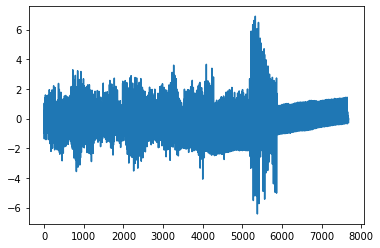

In [16]:
plt.plot(feat)

In [17]:
label

array([0.])

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(train_set.x_shape[1], 5).to(device)

### Training the network

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
loss, acc =  train(model, 30, batch_size, train_loader, criterion,
      optimizer, scheduler, set_size)

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the

| epoch   1 |     2/   12 batches | lr 0.010000 |  7.39 ms | loss 3.48539
| epoch   1 |     4/   12 batches | lr 0.010000 |  4.43 ms | loss 3.64040
| epoch   1 |     6/   12 batches | lr 0.010000 |  2.36 ms | loss 3.76412
| epoch   1 |     8/   12 batches | lr 0.010000 |  2.13 ms | loss 5.11775
| epoch   1 |    10/   12 batches | lr 0.010000 |  2.06 ms | loss 5.89314
| epoch   1 |    12/   12 batches | lr 0.010000 |  2.26 ms | loss 2.40257
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.06s |
-----------------------------------------------------------------------------------------
| epoch   2 |     2/   12 batches | lr 0.009604 |  3.44 ms | loss 5.81513
| epoch   2 |     4/   12 batches | lr 0.009604 |  4.23 ms | loss 0.45836
| epoch   2 |     6/   12 batches | lr 0.009604 |  2.17 ms | loss 1.55416
| epoch   2 |     8/   12 batches | lr 0.009604 |  2.09 ms | loss 3.11922
| epoch   2 |    10/   12 batches | lr 0.009

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the

| epoch  14 |     4/   12 batches | lr 0.007536 |  2.36 ms | loss 0.03466
| epoch  14 |     6/   12 batches | lr 0.007536 | 12.85 ms | loss 0.04736
| epoch  14 |     8/   12 batches | lr 0.007536 |  5.20 ms | loss 0.19358
| epoch  14 |    10/   12 batches | lr 0.007536 |  5.99 ms | loss 0.06940
| epoch  14 |    12/   12 batches | lr 0.007536 |  1.96 ms | loss 0.05493
-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  0.06s |
-----------------------------------------------------------------------------------------
| epoch  15 |     2/   12 batches | lr 0.007386 |  4.79 ms | loss 0.13866
| epoch  15 |     4/   12 batches | lr 0.007386 |  3.39 ms | loss 0.03675
| epoch  15 |     6/   12 batches | lr 0.007386 |  2.17 ms | loss 0.12443
| epoch  15 |     8/   12 batches | lr 0.007386 |  4.43 ms | loss 0.27104
| epoch  15 |    10/   12 batches | lr 0.007386 |  2.10 ms | loss 0.56587
| epoch  15 |    12/   12 batches | lr 0.007

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the

| epoch  19 |    10/   12 batches | lr 0.006812 |  4.76 ms | loss 0.08961
| epoch  19 |    12/   12 batches | lr 0.006812 |  2.55 ms | loss 0.10397
-----------------------------------------------------------------------------------------
| end of epoch  19 | time:  0.04s |
-----------------------------------------------------------------------------------------
| epoch  20 |     2/   12 batches | lr 0.006676 |  3.73 ms | loss 0.31821
| epoch  20 |     4/   12 batches | lr 0.006676 |  3.59 ms | loss 0.08959
| epoch  20 |     6/   12 batches | lr 0.006676 |  2.10 ms | loss 0.13863
| epoch  20 |     8/   12 batches | lr 0.006676 |  2.28 ms | loss 0.12466
| epoch  20 |    10/   12 batches | lr 0.006676 |  2.23 ms | loss 0.19358
| epoch  20 |    12/   12 batches | lr 0.006676 |  1.88 ms | loss 0.13863
-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  0.03s |
------------------------------------------------------------------

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the

| epoch  26 |     4/   12 batches | lr 0.005914 |  2.17 ms | loss 0.10397
| epoch  26 |     6/   12 batches | lr 0.005914 |  7.58 ms | loss 0.08960
| epoch  26 |     8/   12 batches | lr 0.005914 |  4.03 ms | loss 0.06934
| epoch  26 |    10/   12 batches | lr 0.005914 |  2.29 ms | loss 0.12427
| epoch  26 |    12/   12 batches | lr 0.005914 |  2.14 ms | loss 0.00000
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  0.04s |
-----------------------------------------------------------------------------------------
| epoch  27 |     2/   12 batches | lr 0.005796 |  3.01 ms | loss 0.19946
| epoch  27 |     4/   12 batches | lr 0.005796 |  2.08 ms | loss 0.13863
| epoch  27 |     6/   12 batches | lr 0.005796 |  2.01 ms | loss 0.17329
| epoch  27 |     8/   12 batches | lr 0.005796 |  1.96 ms | loss 0.03470
| epoch  27 |    10/   12 batches | lr 0.005796 |  2.09 ms | loss 0.26876
| epoch  27 |    12/   12 batches | lr 0.005

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


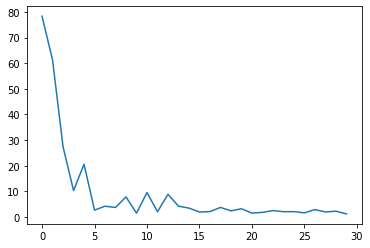

In [20]:
plt.plot(loss)

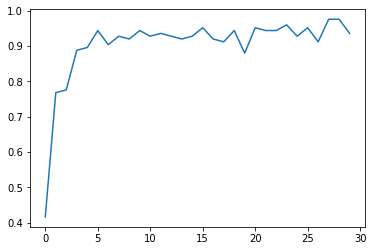

In [21]:
plt.plot(acc)

In [22]:

predictions = torch.tensor([]).to(device)
ground_truth = torch.tensor([]).to(device)
for batch in test_loader:
    data, targets = batch[0], batch[1] # next(iter(test_loader))
    data = Variable(torch.Tensor(data.float())).to(device)
    targets = Variable(torch.Tensor(targets.float())).to(device)
    output = model(data)
    loss = criterion(output, torch.flatten(targets.long()))

predictions = torch.cat((predictions, output), 0)
ground_truth = torch.cat((ground_truth, targets), 0)

In [23]:
predictions = predictions.cpu().detach().numpy()
predictions = np.argmax(predictions, axis=1).reshape(predictions.shape[0], 1)
ground_truth = ground_truth.cpu().cpu().detach().numpy()

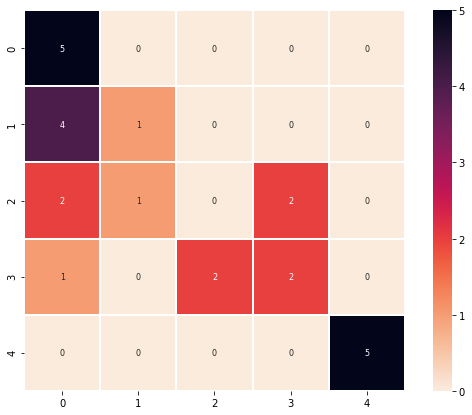

In [24]:
conf_mtx = confusion_matrix(ground_truth, predictions)

conf_df = pd.DataFrame(conf_mtx, index = [i for i in range(5)],
                  columns = [i for i in range(5)])
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, cmap=sns.cm.rocket_r, square=True, linewidths=0.1, annot=True, fmt='d', annot_kws={"fontsize": 8})  
plt.show()

In [25]:
acc = accuracy_score(ground_truth, predictions)
print(f' Acc:\t {acc:.3f}')

 Acc:	 0.520
